# Simple Variational Autoencoder
- Simple NN
- Variational Inference
- Auto-Encoding Variational Bayes

## Variational AutoEncoder
- VAE는 데이터가 생성되는 과정. 즉, 데이터의 확률분포를 학습하기 위한 두 개의 뉴럴네트워크로 구성됨. VAE는 잠재변수 latent variable $z$를 가정하고 있음. 
    1. encoder라고 불리는 뉴럴네트워크는 관측된 데이터 x를 받아 잠재변수 $z$를 만들어내는 역할을 수행 
    2. decoder라 불리는 인공신경망은 encoder가 만든 $z$를 활용해 x를 복원해내는 역할을 수행<br><br>
- 잠재변수 z와 VAE아키텍처 관점에서 이해해 본다면, encoder는 입력 데이터를 추상화하여 잠재적인 특징을 추출하는 역할, decoder는 이러한 잠재적인 특징을 바탕으로 원 데이터로 복원하는 역할을 한다고 해석할 수 있음.

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Load Dataset

In [2]:
model_dir = './save_models/MNIST/VAE'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

mnist_train = dset.MNIST('./data/MNIST', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST('./data/MNIST', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

batch_size = 128

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

## 3. Build Model

## Latent vector $Z$
VAE의 decoder는 정규분포를 전제로 하고 있음. encoder가 만들어낸 $z$의 평균과 분산을 모수로 하는 정규분포를 설정함

$$p(x|z) = N(x| f_{\mu} (z), f_{\sigma} (z)^2 * I)$$

- 최대우도추정(MLE)방식으로 VAE 모델의 파라미터를 추정하려면 다음과 같이 정의된 marginal log-likelihood $\text{log}\  p(x)$를 최대화하면 됨. 아래 식을 최대화하면 모델이 데이터를 그럴싸하게 설명할 수 있게 됨

$$\text{log}\  p(z) = \text{log} \sum_z p(x| f_{\mu} (z), f_{\sigma} (z)^2 * I) p(z)$$

- 위 식은 최적화하기 어려움. $z$는 무수히 많은 경우가 존재할 수 있는데 가능한 모든 $z$에 대해서 고려해야 하기 때문임. 이 때 **변분추론**을 사용하게 됨. **변분추론은 계산이 어려운 확률분포를 다루기 쉬운 $q(z)$로 근사하는 방법임**. $p(x)$는 베이즈정리에서 evidence라고 이름이 붙여진 항인데, 몇가지 수식 유도 과정을 거치면 **evidence의 하한(ELBO)**를 아래와 같이 구할 수 있음

$$\text{log}\ p(x) \ge E_{z \sim q(z)} [\text{log} p(x|z)] - D_{KL}(q(z) || p(z))$$

- 계산이 쉬운 위 부등식 우변, 즉 ELBO를 최대화하려면 $\text{log}\  p(x)$를 최대화할 수 있을 것임. 일반적인 변분추론에서는 $q(z)$를 정규분포로 정함.

$$q(z) = N(\mu_q, \sigma_q^2)$$

- 그런데 데이터 x가 고차원일 때는 $q$를 위화 같이 정하게 되면 학습이 대단히 어려움. 이유는 모든 데이터에 대해 동일한 평균과 분산을 갖는 하나의 정규분포를 가정하기 때문인데, 데이터가 복잡한 것에 비해서 모델이 단순하기 때문임. VAE에서는 이 문제를 해결하기 위해서 아래와 같이 $q$의 파라미터를 $x$에 대한 함수로 설정함

$$q(z|x) = N(\mu_q(x), \sigma_q(x))$$

- ELBO를 최대화하는 방향으로 $q$를 학습하면, $x$가 달라질 때마다 $q$의 분포도 계속적으로 바뀌게 됨($x$에 따라 $q$의 모수(평균, 분산)이 바뀌기 때문). VAE의 encoder에는 x를 받아서 z의 평균과 분산을 만들어내는 인공신경망($f_{\mu}, f_{\sigma}$)가 포함되어 있음.

- 노이즈를 표준정규분포에서 하나 뽑아 ($f_{\mu}, f_{\sigma}$)가 산출한 평군과 분산을 더하고 곱한 이후 sample latent vector z를 만들어냄. 이 과정을 **reparameterization trick**이라고 부름. z를 직접 샘플링하는 것이 아니고 노이즈를 샘플링하는 방식인데, 이렇게 되면 역전파를 통해 encoder가 산출하면 평균과 분산을 업데이트할 수 있게 됨

$$z = \mu(x) + \sigma(x) * \epsilon,\       \epsilon \sim N(0, 1)$$

- VAE는 latent vector z를 노이즈에서 샘플링하셔 만들어내기 대문에 데이터 x가 동일하더라도 z는 얼마든지 달라질 수 있으며 decoder의 최종 결과물 역시 획일적으로 만들어지지 않음.

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.fc1_mu = nn.Linear(input_size, hidden_size)
        self.fc1_sigma = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        
    def encode(self, inputs):
        batch_size = inputs.size(0)
        
        inputs = inputs.view(batch_size, -1)
        mu = self.relu(self.fc1_mu(inputs))
        log_var = self.relu(self.fc1_sigma(inputs))
        return mu, log_var
        
    def forward(self, inputs):
        mu, log_var = self.encode(inputs)
        
        noise = torch.randn(mu.size())
        
        is USE_CUDA:
            noise = noise.cuda()
        
        z = mu + log_var.mul(0.5).exp() * noise
        
        return z, mu, log_var

In [4]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        batch_size = inputs.size(0)
        
        out = self.sigmoid(self.fc1(inputs))
        out = out.view(batch_size, 1, 28, 28)
        
        return out

In [5]:
input_size = 784
hidden_size = 50
output_size = 784

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(hidden_size, output_size)

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

## 4. Loss func & Optims
## VAE's Objective Function
- VAE는 decoder의 사후확률을 학습함. 그렇지만 사후확률을 계산하는 것이 힘들기 때문에 변분추론을 사용했음.
- 변분추론 $q(z)$와 $p(z|x)$사이의 KL Divergence를 계산하고 KLD가 줄어는 방향으로 $q(z)$를 업데이트하면서 $q*(z)$를 만들어냄.

$$D_{KL}(q(z) \| p(z|x)) = D_{KL}(q(z) \| p(z)) + \text{log}\  p(x) - E_{z \sim q(z)}[\text{log} p(x|z)]$$

- q를 정규분포로 설정하고, q의 평균과 분산을 x에 대한 함수로 정의해야 함.

$$\text{log}\  p(x)  = E_{z \sim q(z|x)}[ \text{log}\  p(x|z)] - D_{KL}(q(z|x) \| p(z)) + D_{KL}(q(z|x) \| p(z|x))$$
$$= ELBO + D_{KL}(q(z|x) \| p(z|x))\                     : A$$

- 동일한 확률변수에 대한 KLD값을 항상 양수이기 때문에 아래와 같은 부등식이 성립됨

$$\text{log}\  p(x) \ge E_{z \sim q(z|x)}[\text{log}\  p(x|z)] - D_{KL}(q(z|x), p(z))  = ELBO \                     : B$$

- ELBO를 최대화하면 marginal log-likelihood $\text{log}\  p(x) $를 최대화할 수 있게되며 A와 B를 비교해본다면 ELBO를 최대화한다는 것인 $q(z|x)$, $p(z|x)$ 사이의 KLD를 최소화하는 것임. 딥러닝 모형을 사용하기 위해서 위의 손실함수에 음수를 곱한식이 목적함수로 사용되게 됨

$$L = - E_{z \sim q(z|x)} [\text{log} p(x|z)] + D_{KL}(q(z|x) || p(z))$$

- 우변의 첫번째 항 : reconstruction loss. encoder는 x를 받아서 q로 z를 뽑아내고, decoder는 encoder가 만들어낸 z를 받아 원 데이터인 x를 복원하고 이 둘 사이의 크로스엔트로피를  구함

- 우변의 두번째 항 : KL Divergence Regularizer에 해당. VAE는 z가 표준정규분포라고 가정. 정규분포 간의 KLD는 분석적인 방법으로 도출이 가능함. 이 항을 최소화한다는 것은 q를 표준정규분포에 가깝게 만든다는 것.

$$D_{KL}(q(z|x)\| p(z)) = D_{KL}[N(\mu_{q}(x), \Sigma_{q}(x)) \| N(0, 1)]$$

$$ = \frac{1}{2} \sum_k \big\{ exp( \Sigma_q (x)) + \mu_q (x)^2 - 1 - \Sigma_q (x)  \big\}$$

In [6]:
reconstruction_function = nn.BCELoss(size_average=False)

def loss_function(recon_x, x, mu, log_var):
    BCE = reconstruction_function(recon_x, x)
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    KLD_element = mu.pow(2).add_(log_var.exp()).mul_(-1).add_(1).add_(log_var)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return BCE + KLD

import itertools
parameters = itertools.chain(encoder.parameters(), decoder.parameters())
optimizer = optim.Adam(parameters, lr=0.0005)

## 5. Train

In [7]:
try:
    encoder, decoder = torch.load(model_dir + '/variational_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



In [8]:
num_epoch = 10 # 20

for i in range(num_epoch):
    for j, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        
        if USE_CUDA:
            image = image.cuda()
        
        z, mu, log_var = encoder(image)
        output = decoder(z)
        
        loss = loss_function(output, image, mu, log_var)
        
        loss.backward()
        optimizer.step()
        
        if j % 100 == 0:
            torch.save([encoder, decoder], model_dir + '/variational_autoencoder.pkl')
            # print("[%d/%d] MSE_loss : %0.5f"%(i+1, num_epoch, loss.item()))
            
    print("[%d/%d] loss : %0.5f"%(i+1, num_epoch, loss.item()))

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1/10] loss : 27314.37891
[2/10] loss : 23982.72266
[3/10] loss : 22894.33203
[4/10] loss : 22944.22266
[5/10] loss : 21632.50195
[6/10] loss : 22252.47266
[7/10] loss : 22228.14844
[8/10] loss : 22145.99414
[9/10] loss : 21196.74219
[10/10] loss : 21274.19141


## 6. Check Train Image

torch.Size([128, 28, 28])


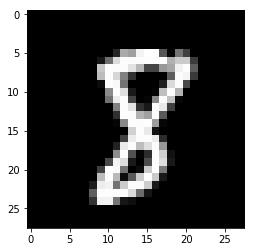

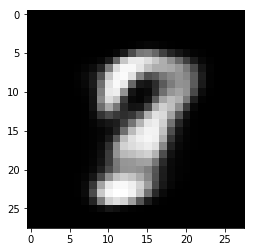

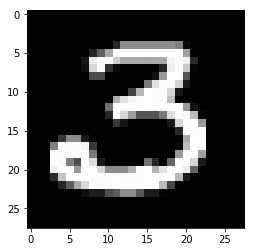

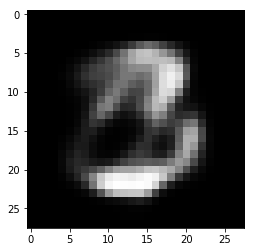

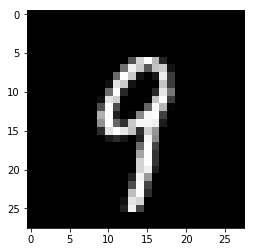

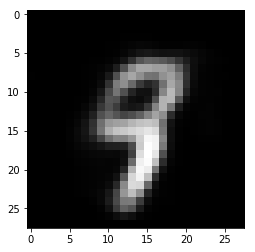

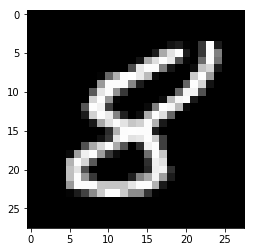

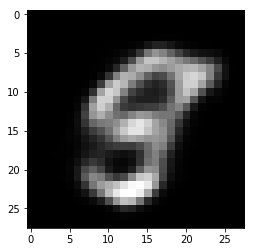

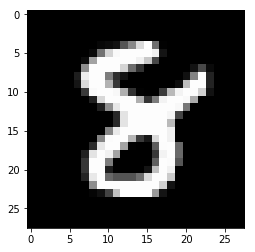

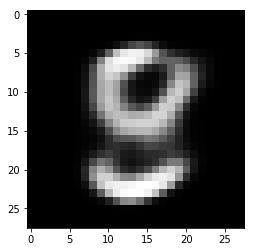

In [9]:
out_img = torch.squeeze(output.cpu().data) # [128, 1, 28, 28] -> [128, 28, 28]
print(out_img.size())

for i in range(5):
    plt.imshow(torch.squeeze(image[i].cpu()).numpy(), cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()

## 7. Check Test Image

In [10]:
for i in range(1):
    for j, (image, label) in enumerate(test_loader):
        
        if USE_CUDA:
            image = image.cuda()
            
        output, mean, var = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)

torch.Size([128, 28, 28])


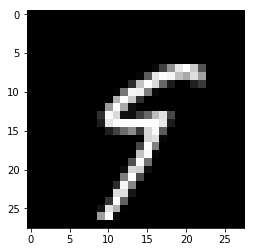

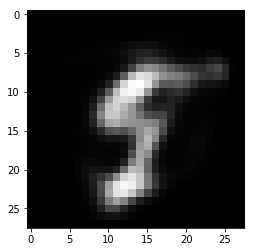

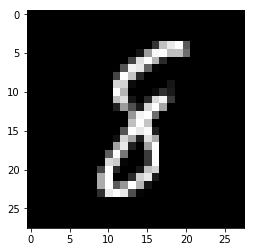

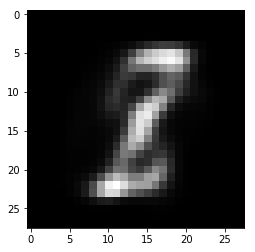

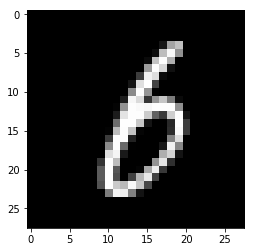

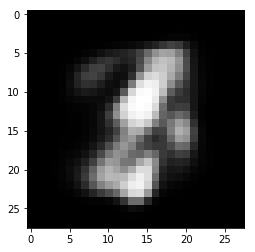

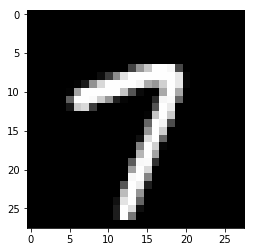

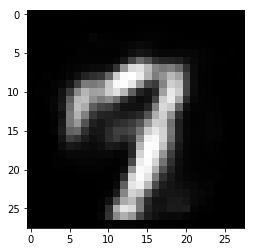

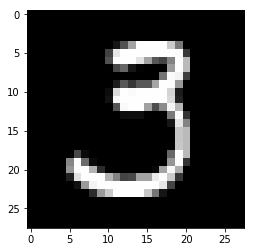

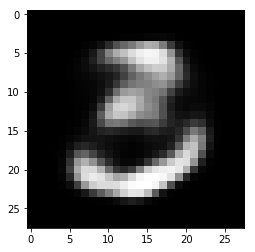

In [11]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()